In [1]:
from lib.abstract_torch import get_device, get_loss, get_optimizer
from lib.dataloader import get_MNIST_loaders
from lib.models import ANN, LoRA_ANN
from lib.train import train_ANN
from lib.test import test
from lib.save import save

import os
import numpy as np
import torch

In [2]:
train_vanilla = True

In [3]:
device = get_device(0)

In [4]:
device

device(type='cuda', index=0)

In [5]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "\\data"
model_path = path + "\\ANN_LoRA\\"

Playable HPs :
- LoRA rank
- trade-off

Other HPs :
- batch_size

In [6]:
# Data parameter
batch_size=64

# Network Architecture
num_inputs = 28*28
num_hidden = 512
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

## Reproducibility

In [7]:
random_seed = 88

## Get MNIST loaders

In [8]:
# We train on MNIST 0 to 4, then each new task is being able to classify a new digit (5 to 9)

In [9]:
train_loaders_list, val_loaders_list, test_loaders_list = get_MNIST_loaders(data_path, batch_size, random_seed, 0.8)

## Train vanilla ANN on digits 0 to 4

In [10]:
if train_vanilla :
    train_loader = train_loaders_list[0]
    test_loader = test_loaders_list[0]

In [11]:
if train_vanilla :
    lr = 1e-3
    num_epochs = 5

In [12]:
if train_vanilla :
    model = ANN(num_inputs, num_hidden, num_outputs, random_seed)

In [13]:
if train_vanilla :
    train_ANN(model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device, random_seed)

100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


In [14]:
if train_vanilla :
    print(test(model, test_loader, batch_size, device))

99.10249999999999


## Save vanilla ANN

In [15]:
if train_vanilla :
    vanilla_path = model_path+"ICL5_state_dict_digits_0_to_4.pth"

In [16]:
if train_vanilla :
    save(vanilla_path, model)

## CL on digits 5 to 9 with LoRA

In [17]:
import optuna
from functools import partial
import matplotlib.pyplot as plt

/home/mathis/miniconda3/envs/.jax_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Greedy HPO

In [18]:
def define_model(trial, model_path, params) :
    lora_rank = trial.suggest_int("lora_rank", 8, 40)
    alpha = trial.suggest_float("alpha", 0.5, 3)
    
    num_inputs, num_hidden, num_outputs, batch_size = params
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size,
                              random_seed)

    return lora_ann_model

def objective(task_number, model_path, params, device, trial) :
    # Define model
    lora_ann_model = define_model(trial, model_path, params).to(device)
    
    # Set HPs
    lr = trial.suggest_float("lr", 5e-5, 1e-3)
    num_epochs = trial.suggest_int("num_epochs", 1, 4)
    
    # Train
    batch_size = params[-1]
    
    train_loader = train_loaders_list[task_number+1]
    #val_loader = val_loaders[task_number]

    train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device, random_seed)
    
    # Test
    test_accs = np.zeros(task_number+1)
    for j in range(task_number+1) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
    
    # Compute score
    mu, sigma = np.mean(test_accs), np.std(test_accs)
    score = mu/sigma
    
    return score

In [19]:
def retrain_and_save_with_best_HPs (best_trial, i, model_path) :
    lora_rank  = best_trial.params["lora_rank"]
    alpha = best_trial.params["alpha"]
    lr = best_trial.params["lr"]
    num_epochs = best_trial.params["num_epochs"]
    
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size,
                              random_seed).to(device)

    # Train
    train_loader = train_loaders_list[i+1]
    #val_loader = val_loaders[i]

    train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device, random_seed)
    
    # Test
    test_accs = np.zeros(10)
    for j in range(10) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
    
    # Save model
    fc1_update = lora_ann_model.model.fc1.weight + alpha*torch.mm(lora_ann_model.l1_lora_A, lora_ann_model.l1_lora_B).T
    lora_ann_model.model.fc1.weight = torch.nn.Parameter(fc1_update)
    
    fc2_update = lora_ann_model.model.fc2.weight + alpha*torch.mm(lora_ann_model.l2_lora_A, lora_ann_model.l2_lora_B).T
    lora_ann_model.model.fc2.weight = torch.nn.Parameter(fc2_update)
    
    model_path = path + f"ICL5_state_dict_digit_{i}.pth"
    save(model_path, lora_ann_model.model)
    
    return test_accs

In [20]:
def call_greedy_HPO(n_trials) :
    # Compute scores of the model trained on the first task
    model_path = path + "\\ANN_LoRA\\ICL5_state_dict_digits_0_to_4.pth"

    lora_rank = 16 # The value of this parameters has no influence
    alpha = 1.8 # The value of this parameter has no influence

    lora_ann_model = LoRA_ANN(lora_rank,
                            alpha, 
                            model_path, 
                            num_inputs, 
                            num_hidden, 
                            num_outputs, 
                            batch_size,
                            random_seed).to(device)

    # Test the model trained on digits 0 to 4
    test_accs = np.zeros(10)
    for j in range(5) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
            
    # Initialize variable to store the best HPs and the scores
    best_params = []
    scores = [test_acc]
    test_accs_matrix = [test_accs]
    mean_test_accs_through_past_tasks = [test_acc]

    for i in range(5,10) :
        print(f"Learning Task {i+1}")
        # Perform HPO
        storage = optuna.storages.InMemoryStorage()
        study = optuna.create_study(storage=storage,
                                    study_name="The Search",
                                    sampler=optuna.samplers.TPESampler(seed=random_seed),
                                    direction = "maximize")
        
        params = num_inputs, num_hidden, num_outputs, batch_size
        partial_objective = partial(objective, i, model_path, params, device)
        study.optimize(partial_objective,
                    n_trials=n_trials,
                    timeout=3600)

        # Retrain and save a model with the best params
        best_trial = study.best_trial
        best_params.append(best_trial.params)
        test_accs = retrain_and_save_with_best_HPs(best_trial, i, model_path) 
        
        model_path = path + f"ICL5_state_dict_digit_{i}.pth"
        
        # Compute and store scores
        mu, sigma = np.mean(test_accs[:i+1]), np.std(test_accs[:i+1])
        score = mu - sigma
        
        scores.append(score)
        test_accs_matrix.append(test_accs)
        mean_test_accs_through_past_tasks.append(mu)
    
    return test_accs_matrix

In [21]:
n_trials_list = [4,8,16,32,64,128]

In [22]:
test_accs_matrix_list = []
for n_trials in n_trials_list :
    test_accs_matrix = call_greedy_HPO(n_trials)
    test_accs_matrix_list += [test_accs_matrix]

[I 2024-05-29 14:37:13,505] A new study created in memory with name: The Search


Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.10it/s]
[I 2024-05-29 14:37:15,981] Trial 0 finished with value: 0.4543613934486291 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.4543613934486291.
100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
[I 2024-05-29 14:37:17,026] Trial 1 finished with value: 0.447213595499958 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.4543613934486291.
100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
[I 2024-05-29 14:37:18,080] Trial 2 finished with value: 0.46364565866558577 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.46364565866558577.
100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
[I 2024-05-29 14:37:20,585] Trial 3 finished with value: 0.5155107826027374 and parameters: {'lora_rank': 10, 'al

Learning Task 7


100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
[I 2024-05-29 14:37:26,127] Trial 0 finished with value: 0.4180467998418433 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.4180467998418433.
100%|██████████| 1/1 [00:00<00:00,  1.95it/s]
[I 2024-05-29 14:37:27,296] Trial 1 finished with value: 0.41220887311668974 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.4180467998418433.
100%|██████████| 1/1 [00:00<00:00,  1.94it/s]
[I 2024-05-29 14:37:28,466] Trial 2 finished with value: 0.437859682717708 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.437859682717708.
100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
[I 2024-05-29 14:37:31,176] Trial 3 finished with value: 0.42701901708847323 and parameters: {'lora_rank': 10, 'alp

Learning Task 8


100%|██████████| 4/4 [00:02<00:00,  1.82it/s]
[I 2024-05-29 14:37:35,598] Trial 0 finished with value: 0.48704876171333955 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.48704876171333955.
100%|██████████| 1/1 [00:00<00:00,  1.82it/s]
[I 2024-05-29 14:37:36,902] Trial 1 finished with value: 0.3856101382065045 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.48704876171333955.
100%|██████████| 1/1 [00:00<00:00,  1.82it/s]
[I 2024-05-29 14:37:38,205] Trial 2 finished with value: 0.4519544596715143 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 0 with value: 0.48704876171333955.
100%|██████████| 4/4 [00:02<00:00,  1.82it/s]
[I 2024-05-29 14:37:41,154] Trial 3 finished with value: 0.39296571524571433 and parameters: {'lora_rank': 10,

Learning Task 9


100%|██████████| 4/4 [00:02<00:00,  1.97it/s]
[I 2024-05-29 14:37:47,174] Trial 0 finished with value: 0.3605802462209124 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.3605802462209124.
100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
[I 2024-05-29 14:37:48,530] Trial 1 finished with value: 0.3564475295409336 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.3605802462209124.
100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
[I 2024-05-29 14:37:49,883] Trial 2 finished with value: 0.3564466605324808 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 0 with value: 0.3605802462209124.
100%|██████████| 4/4 [00:02<00:00,  1.98it/s]
[I 2024-05-29 14:37:52,755] Trial 3 finished with value: 0.3556250119000554 and parameters: {'lora_rank': 10, 'alp

Learning Task 10


100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
[I 2024-05-29 14:37:58,771] Trial 0 finished with value: 0.3333333333333333 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.3333333333333333.
100%|██████████| 1/1 [00:00<00:00,  1.92it/s]
[I 2024-05-29 14:38:00,238] Trial 1 finished with value: 0.3341031676473677 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 1 with value: 0.3341031676473677.
100%|██████████| 1/1 [00:00<00:00,  1.92it/s]
[I 2024-05-29 14:38:01,701] Trial 2 finished with value: 0.33448848510200924 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.33448848510200924.
100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
[I 2024-05-29 14:38:04,728] Trial 3 finished with value: 0.3345700409586696 and parameters: {'lora_rank': 10, 'a

Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
[I 2024-05-29 14:38:10,744] Trial 0 finished with value: 0.4543613934486291 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.4543613934486291.
100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[I 2024-05-29 14:38:11,789] Trial 1 finished with value: 0.447213595499958 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.4543613934486291.
100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
[I 2024-05-29 14:38:12,830] Trial 2 finished with value: 0.46364565866558577 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.46364565866558577.
100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
[I 2024-05-29 14:38:15,288] Trial 3 finished with value: 0.5155107826027374 and parameters: {'lora_rank': 10, 'al

Learning Task 7


100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
[I 2024-05-29 14:38:27,926] Trial 0 finished with value: 0.4256825729994166 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.4256825729994166.
100%|██████████| 1/1 [00:00<00:00,  1.92it/s]
[I 2024-05-29 14:38:29,106] Trial 1 finished with value: 0.41122031226036354 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.4256825729994166.
100%|██████████| 1/1 [00:00<00:00,  1.94it/s]
[I 2024-05-29 14:38:30,280] Trial 2 finished with value: 0.4356290786843347 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.4356290786843347.
100%|██████████| 4/4 [00:02<00:00,  1.94it/s]
[I 2024-05-29 14:38:32,994] Trial 3 finished with value: 0.4517715564010471 and parameters: {'lora_rank': 10, 'al

Learning Task 8


100%|██████████| 4/4 [00:02<00:00,  1.81it/s]
[I 2024-05-29 14:38:46,757] Trial 0 finished with value: 0.41971292508359287 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.41971292508359287.
100%|██████████| 1/1 [00:00<00:00,  1.82it/s]
[I 2024-05-29 14:38:48,070] Trial 1 finished with value: 0.3817767213119653 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.41971292508359287.
100%|██████████| 1/1 [00:00<00:00,  1.82it/s]
[I 2024-05-29 14:38:49,375] Trial 2 finished with value: 0.4035457518387434 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 0 with value: 0.41971292508359287.
100%|██████████| 4/4 [00:02<00:00,  1.82it/s]
[I 2024-05-29 14:38:52,330] Trial 3 finished with value: 0.4713551551602027 and parameters: {'lora_rank': 10, 

Learning Task 9


100%|██████████| 4/4 [00:02<00:00,  1.97it/s]
[I 2024-05-29 14:39:06,883] Trial 0 finished with value: 0.35851322087378107 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.35851322087378107.
100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
[I 2024-05-29 14:39:08,242] Trial 1 finished with value: 0.35438059710926306 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.35851322087378107.
100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
[I 2024-05-29 14:39:09,600] Trial 2 finished with value: 0.3691518186680831 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.3691518186680831.
100%|██████████| 4/4 [00:02<00:00,  1.97it/s]
[I 2024-05-29 14:39:12,476] Trial 3 finished with value: 0.3670089281900601 and parameters: {'lora_rank': 10, 

Learning Task 10


100%|██████████| 4/4 [00:02<00:00,  1.91it/s]
[I 2024-05-29 14:39:26,969] Trial 0 finished with value: 0.33487192212566946 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.33487192212566946.
100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
[I 2024-05-29 14:39:28,434] Trial 1 finished with value: 0.33482541710350266 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.33487192212566946.
100%|██████████| 1/1 [00:00<00:00,  1.92it/s]
[I 2024-05-29 14:39:29,898] Trial 2 finished with value: 0.34890439779943855 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.34890439779943855.
100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
[I 2024-05-29 14:39:32,927] Trial 3 finished with value: 0.36975176578392716 and parameters: {'lora_rank': 1

Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.11it/s]
[I 2024-05-29 14:39:47,932] Trial 0 finished with value: 0.4543613934486291 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.4543613934486291.
100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[I 2024-05-29 14:39:48,980] Trial 1 finished with value: 0.447213595499958 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.4543613934486291.
100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
[I 2024-05-29 14:39:50,033] Trial 2 finished with value: 0.46364565866558577 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.46364565866558577.
100%|██████████| 4/4 [00:01<00:00,  2.11it/s]
[I 2024-05-29 14:39:52,501] Trial 3 finished with value: 0.5155107826027374 and parameters: {'lora_rank': 10, 'al

Learning Task 7


100%|██████████| 4/4 [00:02<00:00,  1.93it/s]
[I 2024-05-29 14:40:19,229] Trial 0 finished with value: 0.4902031046109131 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.4902031046109131.
100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
[I 2024-05-29 14:40:20,409] Trial 1 finished with value: 0.4481145248052659 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.4902031046109131.
100%|██████████| 1/1 [00:00<00:00,  1.94it/s]
[I 2024-05-29 14:40:21,585] Trial 2 finished with value: 0.5969433830330457 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.5969433830330457.
100%|██████████| 4/4 [00:02<00:00,  1.94it/s]
[I 2024-05-29 14:40:24,304] Trial 3 finished with value: 0.6079877521705612 and parameters: {'lora_rank': 10, 'alp

Learning Task 8


100%|██████████| 4/4 [00:02<00:00,  1.81it/s]
[I 2024-05-29 14:40:54,321] Trial 0 finished with value: 0.47155258385683574 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.47155258385683574.
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
[I 2024-05-29 14:40:55,635] Trial 1 finished with value: 0.4040163332218636 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.47155258385683574.
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
[I 2024-05-29 14:40:56,946] Trial 2 finished with value: 0.43700769944633694 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 0 with value: 0.47155258385683574.
100%|██████████| 4/4 [00:02<00:00,  1.82it/s]
[I 2024-05-29 14:40:59,909] Trial 3 finished with value: 0.5854591480310123 and parameters: {'lora_rank': 10,

Learning Task 9


100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
[I 2024-05-29 14:41:32,375] Trial 0 finished with value: 0.37862100375039964 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.37862100375039964.
100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
[I 2024-05-29 14:41:33,763] Trial 1 finished with value: 0.35974909025235635 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.37862100375039964.
100%|██████████| 1/1 [00:00<00:00,  1.96it/s]
[I 2024-05-29 14:41:35,128] Trial 2 finished with value: 0.44990511434127844 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.44990511434127844.
100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
[I 2024-05-29 14:41:38,028] Trial 3 finished with value: 0.39256710603030837 and parameters: {'lora_rank': 1

Learning Task 10


100%|██████████| 4/4 [00:02<00:00,  2.00it/s]
[I 2024-05-29 14:42:09,625] Trial 0 finished with value: 0.3567753712836428 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.3567753712836428.
100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
[I 2024-05-29 14:42:11,069] Trial 1 finished with value: 0.33739855828446136 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.3567753712836428.
100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
[I 2024-05-29 14:42:12,517] Trial 2 finished with value: 0.3915585908884572 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.3915585908884572.
100%|██████████| 4/4 [00:01<00:00,  2.00it/s]
[I 2024-05-29 14:42:15,456] Trial 3 finished with value: 0.42657602438337666 and parameters: {'lora_rank': 10, 'a

Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.11it/s]
[I 2024-05-29 14:42:48,548] Trial 0 finished with value: 0.4543613934486291 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.4543613934486291.
100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
[I 2024-05-29 14:42:49,591] Trial 1 finished with value: 0.447213595499958 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.4543613934486291.
100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[I 2024-05-29 14:42:50,636] Trial 2 finished with value: 0.46364565866558577 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.46364565866558577.
100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
[I 2024-05-29 14:42:53,092] Trial 3 finished with value: 0.5155107826027374 and parameters: {'lora_rank': 10, 'al

Learning Task 7


100%|██████████| 4/4 [00:02<00:00,  1.94it/s]
[I 2024-05-29 14:43:45,916] Trial 0 finished with value: 0.4438606319031721 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.4438606319031721.
100%|██████████| 1/1 [00:00<00:00,  1.94it/s]
[I 2024-05-29 14:43:47,091] Trial 1 finished with value: 0.42159393608858137 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.4438606319031721.
100%|██████████| 1/1 [00:00<00:00,  1.94it/s]
[I 2024-05-29 14:43:48,265] Trial 2 finished with value: 0.5307465911624822 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.5307465911624822.
100%|██████████| 4/4 [00:02<00:00,  1.93it/s]
[I 2024-05-29 14:43:51,000] Trial 3 finished with value: 0.5261284448522984 and parameters: {'lora_rank': 10, 'al

Learning Task 8


100%|██████████| 4/4 [00:02<00:00,  1.90it/s]
[I 2024-05-29 14:44:53,981] Trial 0 finished with value: 0.4467974626625583 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.4467974626625583.
100%|██████████| 1/1 [00:00<00:00,  1.82it/s]
[I 2024-05-29 14:44:55,288] Trial 1 finished with value: 0.40493600189162027 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.4467974626625583.
100%|██████████| 1/1 [00:00<00:00,  1.82it/s]
[I 2024-05-29 14:44:56,599] Trial 2 finished with value: 0.45581342191262314 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.45581342191262314.
100%|██████████| 4/4 [00:02<00:00,  1.81it/s]
[I 2024-05-29 14:44:59,572] Trial 3 finished with value: 0.5036008059614199 and parameters: {'lora_rank': 10, '

Learning Task 9


100%|██████████| 4/4 [00:02<00:00,  1.97it/s]
[I 2024-05-29 14:46:03,337] Trial 0 finished with value: 0.3671785612159922 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.3671785612159922.
100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
[I 2024-05-29 14:46:04,694] Trial 1 finished with value: 0.357683240948201 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.3671785612159922.
100%|██████████| 1/1 [00:00<00:00,  1.95it/s]
[I 2024-05-29 14:46:06,058] Trial 2 finished with value: 0.4311681976240153 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.4311681976240153.
100%|██████████| 4/4 [00:02<00:00,  1.97it/s]
[I 2024-05-29 14:46:08,935] Trial 3 finished with value: 0.37072357492577446 and parameters: {'lora_rank': 10, 'alp

Learning Task 10


100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
[I 2024-05-29 14:47:10,438] Trial 0 finished with value: 0.3705229347997726 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.3705229347997726.
100%|██████████| 1/1 [00:00<00:00,  1.90it/s]
[I 2024-05-29 14:47:11,909] Trial 1 finished with value: 0.33850424380321775 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.3705229347997726.
100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
[I 2024-05-29 14:47:13,376] Trial 2 finished with value: 0.37049009403726785 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 0 with value: 0.3705229347997726.
100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
[I 2024-05-29 14:47:16,402] Trial 3 finished with value: 0.42111289444955935 and parameters: {'lora_rank': 10, '

Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.11it/s]
[I 2024-05-29 14:48:29,954] Trial 0 finished with value: 0.4543613934486291 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.4543613934486291.
100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[I 2024-05-29 14:48:31,000] Trial 1 finished with value: 0.447213595499958 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.4543613934486291.
100%|██████████| 1/1 [00:00<00:00,  2.05it/s]
[I 2024-05-29 14:48:32,058] Trial 2 finished with value: 0.46364565866558577 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.46364565866558577.
100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
[I 2024-05-29 14:48:34,521] Trial 3 finished with value: 0.5155107826027374 and parameters: {'lora_rank': 10, 'al

Learning Task 7


100%|██████████| 4/4 [00:02<00:00,  1.94it/s]
[I 2024-05-29 14:50:19,483] Trial 0 finished with value: 0.48339550325326364 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.48339550325326364.
100%|██████████| 1/1 [00:00<00:00,  1.95it/s]
[I 2024-05-29 14:50:20,667] Trial 1 finished with value: 0.43373789823534387 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.48339550325326364.
100%|██████████| 1/1 [00:00<00:00,  1.95it/s]
[I 2024-05-29 14:50:21,848] Trial 2 finished with value: 0.6139169793265153 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.6139169793265153.
100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
[I 2024-05-29 14:50:24,560] Trial 3 finished with value: 0.5764148136561482 and parameters: {'lora_rank': 10, 

Learning Task 8


100%|██████████| 4/4 [00:02<00:00,  1.81it/s]
[I 2024-05-29 14:52:26,943] Trial 0 finished with value: 0.461681044173328 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.461681044173328.
100%|██████████| 1/1 [00:00<00:00,  1.82it/s]
[I 2024-05-29 14:52:28,253] Trial 1 finished with value: 0.400008588491218 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.461681044173328.
100%|██████████| 1/1 [00:00<00:00,  1.82it/s]
[I 2024-05-29 14:52:29,559] Trial 2 finished with value: 0.4371045930519869 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 0 with value: 0.461681044173328.
100%|██████████| 4/4 [00:02<00:00,  1.79it/s]
[I 2024-05-29 14:52:32,557] Trial 3 finished with value: 0.5241348741848479 and parameters: {'lora_rank': 10, 'alpha': 

Learning Task 9


100%|██████████| 4/4 [00:02<00:00,  1.96it/s]
[I 2024-05-29 14:55:00,198] Trial 0 finished with value: 0.367591508089157 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.367591508089157.
100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
[I 2024-05-29 14:55:01,591] Trial 1 finished with value: 0.35768673166514003 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.367591508089157.
100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
[I 2024-05-29 14:55:02,962] Trial 2 finished with value: 0.41799950793732665 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.41799950793732665.
100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
[I 2024-05-29 14:55:05,859] Trial 3 finished with value: 0.3739963427796756 and parameters: {'lora_rank': 10, 'alp

Learning Task 10


100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
[I 2024-05-29 14:57:06,969] Trial 0 finished with value: 0.3524446598282959 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.3524446598282959.
100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
[I 2024-05-29 14:57:08,399] Trial 1 finished with value: 0.3366531185868699 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.3524446598282959.
100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
[I 2024-05-29 14:57:09,831] Trial 2 finished with value: 0.3694327096640846 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.3694327096640846.
100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
[I 2024-05-29 14:57:12,740] Trial 3 finished with value: 0.41703961209998697 and parameters: {'lora_rank': 10, 'al

Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]
[I 2024-05-29 14:59:29,655] Trial 0 finished with value: 0.4543613934486291 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.4543613934486291.
100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
[I 2024-05-29 14:59:30,683] Trial 1 finished with value: 0.447213595499958 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.4543613934486291.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-29 14:59:31,718] Trial 2 finished with value: 0.46364565866558577 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.46364565866558577.
100%|██████████| 4/4 [00:01<00:00,  2.23it/s]
[I 2024-05-29 14:59:34,080] Trial 3 finished with value: 0.5155107826027374 and parameters: {'lora_rank': 10, 'al

Learning Task 7


100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
[I 2024-05-29 15:03:19,112] Trial 0 finished with value: 0.48339550325326364 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.48339550325326364.
100%|██████████| 1/1 [00:00<00:00,  2.05it/s]
[I 2024-05-29 15:03:20,256] Trial 1 finished with value: 0.43373789823534387 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.48339550325326364.
100%|██████████| 1/1 [00:00<00:00,  2.05it/s]
[I 2024-05-29 15:03:21,402] Trial 2 finished with value: 0.6139169793265153 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.6139169793265153.
100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
[I 2024-05-29 15:03:24,008] Trial 3 finished with value: 0.5764148136561482 and parameters: {'lora_rank': 10, 

Learning Task 8


100%|██████████| 4/4 [00:02<00:00,  1.91it/s]
[I 2024-05-29 15:07:29,290] Trial 0 finished with value: 0.44276801528318016 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.44276801528318016.
100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
[I 2024-05-29 15:07:30,569] Trial 1 finished with value: 0.4016559456837969 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.44276801528318016.
100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
[I 2024-05-29 15:07:31,851] Trial 2 finished with value: 0.4241670983798888 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 0 with value: 0.44276801528318016.
100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
[I 2024-05-29 15:07:34,688] Trial 3 finished with value: 0.505793239617169 and parameters: {'lora_rank': 10, '

Learning Task 9


100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
[I 2024-05-29 15:11:50,809] Trial 0 finished with value: 0.37045979588070027 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.37045979588070027.
100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
[I 2024-05-29 15:11:52,150] Trial 1 finished with value: 0.3580974939396308 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.37045979588070027.
100%|██████████| 1/1 [00:00<00:00,  2.08it/s]
[I 2024-05-29 15:11:53,480] Trial 2 finished with value: 0.413866442656425 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.413866442656425.
100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
[I 2024-05-29 15:11:56,267] Trial 3 finished with value: 0.3870125375139216 and parameters: {'lora_rank': 10, 'al

Learning Task 10


100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
[I 2024-05-29 15:16:19,148] Trial 0 finished with value: 0.3651713174490381 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.3651713174490381.
100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
[I 2024-05-29 15:16:20,589] Trial 1 finished with value: 0.33593172382379294 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.3651713174490381.
100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-29 15:16:22,030] Trial 2 finished with value: 0.38867083191378426 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.38867083191378426.
100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
[I 2024-05-29 15:16:24,956] Trial 3 finished with value: 0.4362427927920245 and parameters: {'lora_rank': 10, '

In [23]:
def visualize_HPO_matrix(test_accs_matrix, n_trials, mode="greedy", savefig=False,):
    plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
    plt.yticks(np.arange(6), np.arange(4, 10))
    plt.xlabel("Accuracy on digit j...")
    plt.ylabel("...after training on digit i")
    plt.colorbar()
    if mode == "greedy" :
        plt.title(f"Result of greedy HPO with {n_trials} trials per task")
    else :
        plt.title(f"Result of cheated HPO")
    if savefig :
        if mode == "greedy" :
            plt.savefig(f"results/ICL5_{n_trials}_trial_greedy_HPO_matrix_LoRA.png")
        else :
            plt.savefig(f"results/ICL5_cheated_HPO_matrix_LoRA.png")
    plt.show()

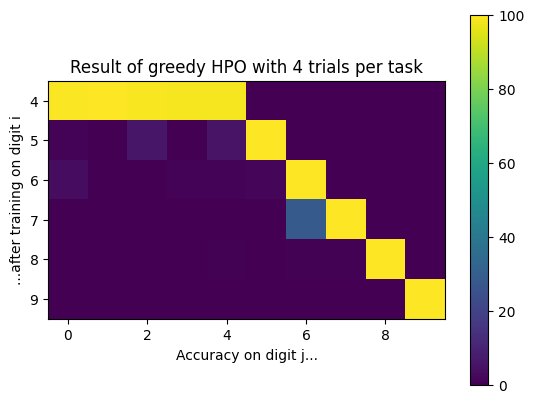

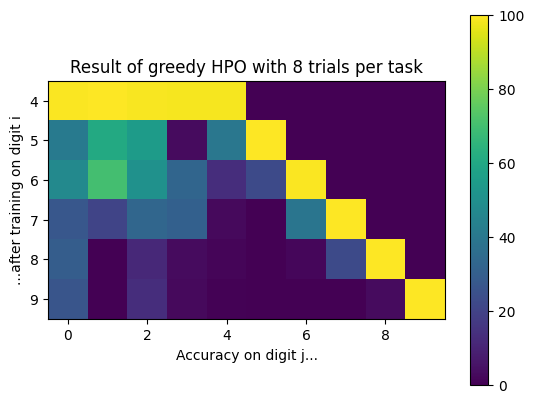

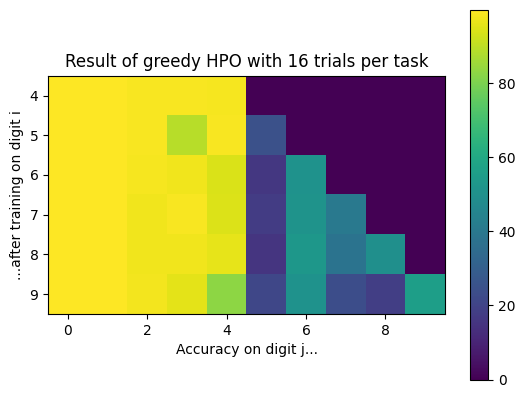

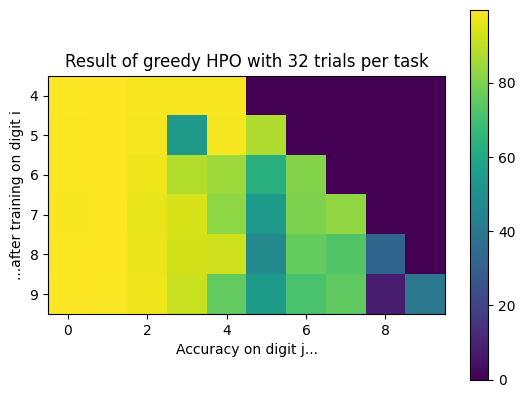

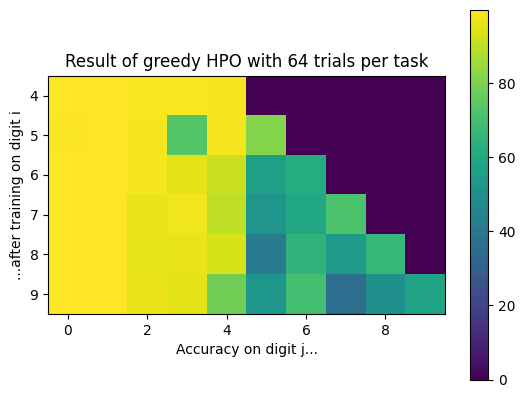

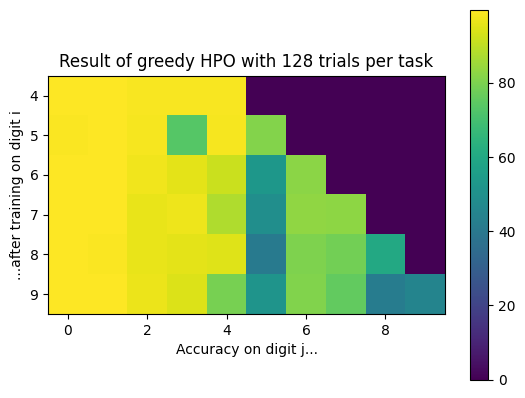

In [24]:
for test_accs_matrix, n_trials in zip(test_accs_matrix_list, n_trials_list) :
    visualize_HPO_matrix(test_accs_matrix, n_trials, mode="greedy", savefig=True)

In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [38]:
def visualize_HPO_curve(test_accs_matrix_list, n_trials_list, mode="greedy", savefig=False):
    # Normalize n_trials values for the colormap
    norm = mcolors.LogNorm(vmin=min(n_trials_list), vmax=max(n_trials_list))
    colormap = cm.viridis

    fig, ax = plt.subplots(figsize=(10, 6))
    for test_accs_matrix, n_trials in zip(test_accs_matrix_list, n_trials_list):
        mean_accs = np.array(test_accs_matrix).sum(1) / np.arange(5, 11, 1)
        color = colormap(norm(n_trials))
        ax.plot(range(4,10), mean_accs, label=f"{n_trials} trials", color=color)
    
    ax.set_xlabel("Number of classes trained")
    ax.set_ylabel("Average accuracy for classes trained so far")
    ax.set_ylim(0, 100)
    if mode == "greedy" :
        ax.set_title("Result of greedy HPO with various numbers of trials")
    else :
        ax.set_title("Result of cheated HPO")

    # Create a scalar mappable for the color bar
    sm = cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Number of Trials')

    ax.legend(loc='lower left')
    
    if savefig:
        if mode == "greedy" :
            plt.savefig(f"results/ICL5_greedy_HPO_curve_LoRA.png")
        elif mode == "optigreedy" :
            plt.savefig(f"results/ICL5_optigreedy_HPO_curve_LoRA.png")
        else :
            plt.savefig(f"results/ICL5_cheated_HPO_curve_LoRA.png")
    plt.show()


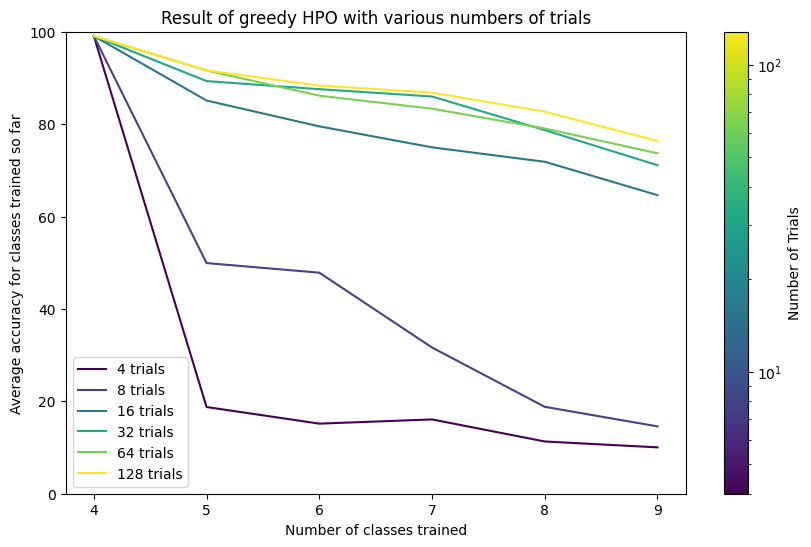

In [39]:
visualize_HPO_curve(test_accs_matrix_list, n_trials_list, mode="greedy", savefig=True)

### Refined greedy HPO

In [28]:
def call_refined_geedy_HPO(n_trials_task_wise) :
    # Compute scores of the model trained on the first task
    model_path = path + "\\ANN_LoRA\\ICL5_state_dict_digits_0_to_4.pth"

    lora_rank = 16 # The value of this parameters has no influence
    alpha = 1.8 # The value of this parameter has no influence

    lora_ann_model = LoRA_ANN(lora_rank,
                            alpha, 
                            model_path, 
                            num_inputs, 
                            num_hidden, 
                            num_outputs, 
                            batch_size,
                            random_seed).to(device)

    # Test the model trained on digits 0 to 4
    test_accs = np.zeros(10)
    for j in range(5) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
            
    # Initialize variable to store the best HPs and the scores
    best_params = []
    scores = [test_acc]
    test_accs_matrix = [test_accs]
    mean_test_accs_through_past_tasks = [test_acc]

    for i in range(5,10) :
        print(f"Learning Task {i+1}")
        # Perform HPO
        storage = optuna.storages.InMemoryStorage()
        study = optuna.create_study(storage=storage,
                                    study_name="The Search",
                                    sampler=optuna.samplers.TPESampler(seed=random_seed),
                                    direction = "maximize")
        
        params = num_inputs, num_hidden, num_outputs, batch_size
        partial_objective = partial(objective, i, model_path, params, device)
        study.optimize(partial_objective,
                    n_trials=n_trials_task_wise[i-5],
                    timeout=3600)

        # Retrain and save a model with the best params
        best_trial = study.best_trial
        best_params.append(best_trial.params)
        test_accs = retrain_and_save_with_best_HPs(best_trial, i, model_path) 
        
        model_path = path + f"ICL5_state_dict_digit_{i}.pth"
        
        # Compute and store scores
        mu, sigma = np.mean(test_accs[:i+1]), np.std(test_accs[:i+1])
        score = mu - sigma
        
        scores.append(score)
        test_accs_matrix.append(test_accs)
        mean_test_accs_through_past_tasks.append(mu)
    
    return test_accs_matrix

In [29]:
n_trials_task_wise = [32,32,64,64,128]

In [30]:
refined_test_accs_matrix = call_refined_geedy_HPO(n_trials_task_wise)

[I 2024-05-29 15:20:20,158] A new study created in memory with name: The Search


Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]
[I 2024-05-29 15:20:22,537] Trial 0 finished with value: 0.4543613934486291 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.4543613934486291.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-29 15:20:23,558] Trial 1 finished with value: 0.447213595499958 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.4543613934486291.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-29 15:20:24,578] Trial 2 finished with value: 0.46364565866558577 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.46364565866558577.
100%|██████████| 4/4 [00:01<00:00,  2.24it/s]
[I 2024-05-29 15:20:26,938] Trial 3 finished with value: 0.5155107826027374 and parameters: {'lora_rank': 10, 'al

Learning Task 7


100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
[I 2024-05-29 15:21:18,507] Trial 0 finished with value: 0.4438606319031721 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.4438606319031721.
100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
[I 2024-05-29 15:21:19,660] Trial 1 finished with value: 0.42159393608858137 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.4438606319031721.
100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-29 15:21:20,819] Trial 2 finished with value: 0.5307465911624822 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.5307465911624822.
100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
[I 2024-05-29 15:21:23,429] Trial 3 finished with value: 0.5261284448522984 and parameters: {'lora_rank': 10, 'al

Learning Task 8


100%|██████████| 4/4 [00:02<00:00,  1.91it/s]
[I 2024-05-29 15:22:24,601] Trial 0 finished with value: 0.4467974626625583 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.4467974626625583.
100%|██████████| 1/1 [00:00<00:00,  1.90it/s]
[I 2024-05-29 15:22:25,889] Trial 1 finished with value: 0.40493600189162027 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.4467974626625583.
100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
[I 2024-05-29 15:22:27,172] Trial 2 finished with value: 0.45581342191262314 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.45581342191262314.
100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
[I 2024-05-29 15:22:30,020] Trial 3 finished with value: 0.5036008059614199 and parameters: {'lora_rank': 10, '

Learning Task 9


100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
[I 2024-05-29 15:24:29,451] Trial 0 finished with value: 0.37374556768654676 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.37374556768654676.
100%|██████████| 1/1 [00:00<00:00,  2.08it/s]
[I 2024-05-29 15:24:30,791] Trial 1 finished with value: 0.3580974939396308 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.37374556768654676.
100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
[I 2024-05-29 15:24:32,127] Trial 2 finished with value: 0.43401619544867454 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.43401619544867454.
100%|██████████| 4/4 [00:01<00:00,  2.08it/s]
[I 2024-05-29 15:24:34,910] Trial 3 finished with value: 0.3727789593116761 and parameters: {'lora_rank': 10,

Learning Task 10


100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
[I 2024-05-29 15:26:44,502] Trial 0 finished with value: 0.34973322060653483 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.34973322060653483.
100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
[I 2024-05-29 15:26:45,963] Trial 1 finished with value: 0.33593172382379294 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.34973322060653483.
100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
[I 2024-05-29 15:26:47,406] Trial 2 finished with value: 0.38256539268280454 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.38256539268280454.
100%|██████████| 4/4 [00:02<00:00,  1.99it/s]
[I 2024-05-29 15:26:50,380] Trial 3 finished with value: 0.42936300201713895 and parameters: {'lora_rank': 1

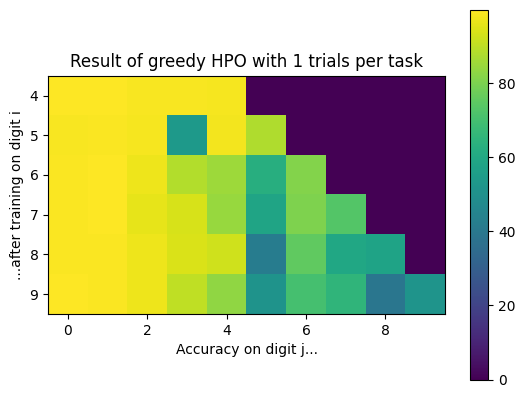

In [36]:
visualize_HPO_matrix(refined_test_accs_matrix, 1, mode="greedy", savefig=True)

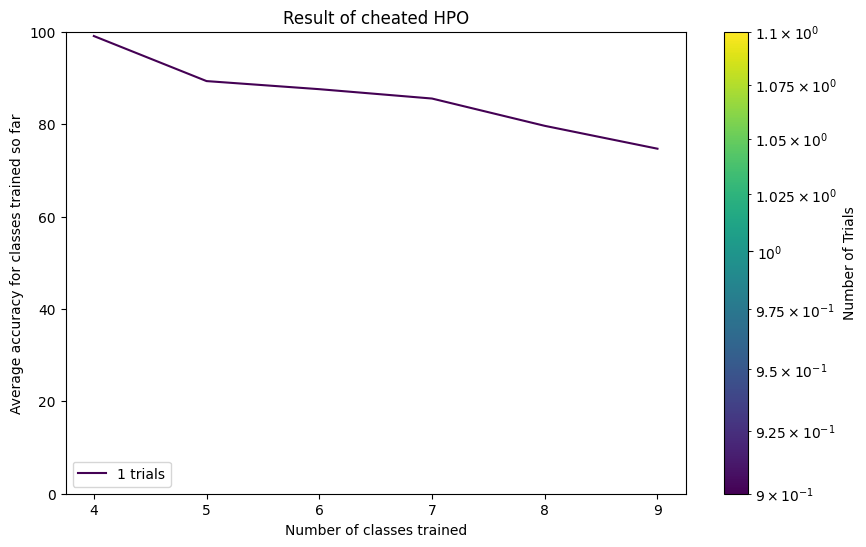

In [40]:
visualize_HPO_curve([refined_test_accs_matrix], [1], mode="optigreedy", savefig=True)

## Leaky HPO

In [41]:
def define_model(model_path, params, lora_rank, alpha) :
    num_inputs, num_hidden, num_outputs, batch_size = params
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size,
                              random_seed)

    return lora_ann_model

def objective(model_path, params, device, trial) :
    # Set HPs
    lr = trial.suggest_float("lr", 1e-4, 3e-4)
    num_epochs = trial.suggest_categorical("num_epochs", [1]) # trial.suggest_int("num_epochs", 1, 4)
    lora_rank = trial.suggest_int("lora_rank", 8, 40)
    alpha = trial.suggest_categorical("alpha", [1.8,1.9,2,2.1])

    l1_sum, l2_sum = 0, 0
    for i in range(5,10) :
        # Define model
        lora_ann_model = define_model(model_path, params, lora_rank, alpha).to(device)
        
        # Train
        batch_size = params[-1]
        
        train_loader = train_loaders_list[i+1]

        train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device, random_seed)

        # Save LoRA weights for future average
        l1_sum += torch.mm(lora_ann_model.l1_lora_A, lora_ann_model.l1_lora_B).T
        l2_sum += torch.mm(lora_ann_model.l2_lora_A, lora_ann_model.l2_lora_B).T

        # Save model
        if i < 9 :
            fc1_update = lora_ann_model.model.fc1.weight #+ alpha*torch.mm(lora_ann_model.l1_lora_A, lora_ann_model.l1_lora_B).T
            lora_ann_model.model.fc1.weight = torch.nn.Parameter(fc1_update)
            
            fc2_update = lora_ann_model.model.fc2.weight #+ alpha*torch.mm(lora_ann_model.l2_lora_A, lora_ann_model.l2_lora_B).T
            lora_ann_model.model.fc2.weight = torch.nn.Parameter(fc2_update)
        else :
            fc1_update = lora_ann_model.model.fc1.weight + alpha*l1_sum/5
            lora_ann_model.model.fc1.weight = torch.nn.Parameter(fc1_update)
            
            fc2_update = lora_ann_model.model.fc2.weight + alpha*l2_sum/5
            lora_ann_model.model.fc2.weight = torch.nn.Parameter(fc2_update)
        model_path = path + f"ICL5_state_dict_digit_{i}.pth"
        save(model_path, lora_ann_model.model)

    # Test
    test_accs = np.zeros(10)
    for j in range(10) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
    
    # Compute score
    print(test_accs)
    mu = np.mean(test_accs)
    
    return mu

In [42]:
def call_leaky_HPO(n_trials) :
    # Compute scores of the model trained on the first task
    model_path = path + "\\ANN_LoRA\\ICL5_state_dict_digits_0_to_4.pth"

    lora_rank = 16 # The value of this parameters has no influence
    alpha = 1.8 # The value of this parameter has no influence

    lora_ann_model = LoRA_ANN(lora_rank,
                            alpha, 
                            model_path, 
                            num_inputs, 
                            num_hidden, 
                            num_outputs, 
                            batch_size,
                            random_seed).to(device)

    # Test the model trained on digits 0 to 4
    test_accs = np.zeros(10)
    for j in range(5) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
            
    # Initialize variable to store the best HPs and the scores
    test_accs_matrix = [test_accs]

    # Perform HPO
    storage = optuna.storages.InMemoryStorage()
    study = optuna.create_study(storage=storage,
                                study_name="The Search",
                                sampler=optuna.samplers.TPESampler(seed=random_seed),
                                direction = "maximize")
    
    params = num_inputs, num_hidden, num_outputs, batch_size
    partial_objective = partial(objective, model_path, params, device)
    study.optimize(partial_objective,
                   n_trials=n_trials,
                   timeout=3600)
    
    # Return results of best study
    best_trial = study.best_trial
    best_score = best_trial.value
    best_params = best_trial.params

    # Retrain with best parameters
    for i in range(5,10) :
        test_accs = retrain_and_save_with_best_HPs (best_trial, i, model_path)
        model_path = path + f"ICL5_state_dict_digit_{i}.pth"
        test_accs_matrix += [test_accs]
    
    return test_accs_matrix

In [43]:
test_accs_matrix = call_leaky_HPO(30)

[I 2024-05-29 15:43:57,370] A new study created in memory with name: The Search
100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
[I 2024-05-29 15:44:00,788] Trial 0 finished with value: 23.773254656862747 and parameters: {'lr': 0.00022951020987060466, 'num_epochs': 1, 'lora_rank': 24, 'alpha': 1.9}. Best is trial 0 with value: 23.773254656862747.


[44.06266667 19.21058824 48.730625   24.584       1.24866667  0.
  0.          0.          0.         99.896     ]


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-29 15:44:04,206] Trial 1 finished with value: 30.5792330882353 and parameters: {'lr': 0.00024346767641828014, 'num_epochs': 1, 'lora_rank': 15, 'alpha': 2}. Best is trial 1 with value: 30.5792330882353.


[34.58266667 61.76470588 67.675625   40.83266667  1.04066667  0.
  0.          0.          0.         99.896     ]


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-29 15:44:07,618] Trial 2 finished with value: 47.3803080882353 and parameters: {'lr': 0.00011798443893679071, 'num_epochs': 1, 'lora_rank': 36, 'alpha': 1.9}. Best is trial 2 with value: 47.3803080882353.


[96.87666667 96.32470588 95.704375   73.646      14.16666667  0.
  0.          0.          0.         97.08466667]


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-29 15:44:11,028] Trial 3 finished with value: 42.49338504901961 and parameters: {'lr': 0.0002162891485881896, 'num_epochs': 1, 'lora_rank': 11, 'alpha': 1.8}. Best is trial 2 with value: 47.3803080882353.


[91.876      85.38705882 89.648125   49.68666667  9.58466667  0.
  0.          0.          0.         98.75133333]


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-29 15:44:14,439] Trial 4 finished with value: 49.72448186274511 and parameters: {'lr': 0.00013327911538634009, 'num_epochs': 1, 'lora_rank': 22, 'alpha': 1.9}. Best is trial 4 with value: 49.72448186274511.


[99.272      98.89823529 98.34125    85.938      20.002       0.
  0.          0.          0.         94.79333333]


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-29 15:44:17,859] Trial 5 finished with value: 52.047078186274504 and parameters: {'lr': 0.00010643255647485577, 'num_epochs': 1, 'lora_rank': 34, 'alpha': 1.8}. Best is trial 5 with value: 52.047078186274504.


[99.48       98.89882353 98.340625   89.89733333 40.41666667  0.
  0.          0.          0.         93.43733333]


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-29 15:44:21,289] Trial 6 finished with value: 18.952713970588235 and parameters: {'lr': 0.00029572879231709977, 'num_epochs': 1, 'lora_rank': 18, 'alpha': 1.8}. Best is trial 5 with value: 52.047078186274504.


[ 27.708       10.66176471  34.179375    16.24933333   0.72866667
   0.           0.           0.           0.         100.        ]


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
[I 2024-05-29 15:44:24,715] Trial 7 finished with value: 18.131145833333335 and parameters: {'lr': 0.00028411059323876927, 'num_epochs': 1, 'lora_rank': 28, 'alpha': 2}. Best is trial 5 with value: 52.047078186274504.


[ 21.354       12.04        35.938125    11.25066667   0.72866667
   0.           0.           0.           0.         100.        ]


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
[I 2024-05-29 15:44:28,163] Trial 8 finished with value: 18.957704166666666 and parameters: {'lr': 0.0002636136560104354, 'num_epochs': 1, 'lora_rank': 30, 'alpha': 1.8}. Best is trial 5 with value: 52.047078186274504.


[ 36.77         7.26        33.984375    10.31333333   1.24933333
   0.           0.           0.           0.         100.        ]


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
[I 2024-05-29 15:44:31,589] Trial 9 finished with value: 28.82264632352941 and parameters: {'lr': 0.0001767414825908611, 'num_epochs': 1, 'lora_rank': 32, 'alpha': 1.9}. Best is trial 5 with value: 52.047078186274504.


[66.562      16.36058824 71.971875   31.04066667  2.60333333  0.
  0.          0.          0.         99.688     ]


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]
[I 2024-05-29 15:44:35,040] Trial 10 finished with value: 29.34105661764706 and parameters: {'lr': 0.00016703325921932198, 'num_epochs': 1, 'lora_rank': 40, 'alpha': 2.1}. Best is trial 5 with value: 52.047078186274504.


[47.812      53.95294118 64.355625   25.83266667  1.56133333  0.
  0.          0.          0.         99.896     ]


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
[I 2024-05-29 15:44:38,492] Trial 11 finished with value: 53.649498039215686 and parameters: {'lr': 0.00010638919186788998, 'num_epochs': 1, 'lora_rank': 22, 'alpha': 2.1}. Best is trial 11 with value: 53.649498039215686.


[99.792      99.35764706 99.22       93.75133333 58.332       0.
  0.          0.          0.         86.042     ]


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
[I 2024-05-29 15:44:41,924] Trial 12 finished with value: 54.15041470588235 and parameters: {'lr': 0.00010225827526298429, 'num_epochs': 1, 'lora_rank': 20, 'alpha': 2.1}. Best is trial 12 with value: 54.15041470588235.


[99.688      99.35764706 99.1225     94.37666667 61.146       0.
  0.          0.          0.         87.81333333]


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-29 15:44:45,346] Trial 13 finished with value: 47.70712573529412 and parameters: {'lr': 0.00014631431308122938, 'num_epochs': 1, 'lora_rank': 19, 'alpha': 2.1}. Best is trial 12 with value: 54.15041470588235.


[95.83466667 97.33588235 94.629375   70.83333333 22.18666667  0.
  0.          0.          0.         96.25133333]


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-29 15:44:48,774] Trial 14 finished with value: 50.73102450980392 and parameters: {'lr': 0.00010130711136233675, 'num_epochs': 1, 'lora_rank': 9, 'alpha': 2.1}. Best is trial 12 with value: 54.15041470588235.


[99.584      99.44941176 99.3175     97.39733333 90.208       0.
  0.          0.          0.         21.354     ]


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-29 15:44:52,215] Trial 15 finished with value: 34.175865686274506 and parameters: {'lr': 0.00018677540342286602, 'num_epochs': 1, 'lora_rank': 26, 'alpha': 2.1}. Best is trial 12 with value: 54.15041470588235.


[67.81333333 69.66882353 74.9025     27.70733333  2.08266667  0.
  0.          0.          0.         99.584     ]


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
[I 2024-05-29 15:44:55,650] Trial 16 finished with value: 48.90826985294118 and parameters: {'lr': 0.00014865177920082522, 'num_epochs': 1, 'lora_rank': 15, 'alpha': 2.1}. Best is trial 12 with value: 54.15041470588235.


[96.46066667 98.43882353 96.681875   86.66666667 12.604       0.
  0.          0.          0.         98.23066667]


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-29 15:44:59,070] Trial 17 finished with value: 49.29547941176471 and parameters: {'lr': 0.00012619554877718277, 'num_epochs': 1, 'lora_rank': 20, 'alpha': 2.1}. Best is trial 12 with value: 54.15041470588235.


[98.95933333 97.79529412 97.6575     83.334      19.47866667  0.
  0.          0.          0.         95.73      ]


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
[I 2024-05-29 15:45:02,484] Trial 18 finished with value: 50.31391789215687 and parameters: {'lr': 0.00015655106296824477, 'num_epochs': 1, 'lora_rank': 13, 'alpha': 2.1}. Best is trial 12 with value: 54.15041470588235.


[99.168      98.80647059 97.559375   84.68733333 28.438       0.
  0.          0.          0.         94.48      ]


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]
[I 2024-05-29 15:45:05,915] Trial 19 finished with value: 47.12204093137255 and parameters: {'lr': 0.00012981470416512493, 'num_epochs': 1, 'lora_rank': 24, 'alpha': 2.1}. Best is trial 12 with value: 54.15041470588235.


[96.77333333 97.24411765 93.555625   73.54266667 12.916       0.
  0.          0.          0.         97.18866667]


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-29 15:45:09,338] Trial 20 finished with value: 42.34247598039216 and parameters: {'lr': 0.00020264194105619723, 'num_epochs': 1, 'lora_rank': 17, 'alpha': 2}. Best is trial 12 with value: 54.15041470588235.


[81.354      91.36117647 89.35625    57.49866667  4.68733333  0.
  0.          0.          0.         99.16733333]


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-29 15:45:12,761] Trial 21 finished with value: 52.76522401960784 and parameters: {'lr': 0.00010256307321153289, 'num_epochs': 1, 'lora_rank': 34, 'alpha': 1.8}. Best is trial 12 with value: 54.15041470588235.


[99.584      98.89882353 98.43875    90.73       48.12466667  0.
  0.          0.          0.         91.876     ]


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
[I 2024-05-29 15:45:16,184] Trial 22 finished with value: 53.14435906862745 and parameters: {'lr': 0.00010332262523999492, 'num_epochs': 1, 'lora_rank': 27, 'alpha': 1.8}. Best is trial 12 with value: 54.15041470588235.


[99.48       99.26588235 98.634375   93.542      48.64666667  0.
  0.          0.          0.         91.87466667]


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-29 15:45:19,601] Trial 23 finished with value: 49.62963088235295 and parameters: {'lr': 0.00012160958721554364, 'num_epochs': 1, 'lora_rank': 27, 'alpha': 1.8}. Best is trial 12 with value: 54.15041470588235.


[98.54266667 98.80705882 97.07125    85.62666667 20.10333333  0.
  0.          0.          0.         96.14533333]


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
[I 2024-05-29 15:45:23,016] Trial 24 finished with value: 45.66646004901961 and parameters: {'lr': 0.0001399984805285662, 'num_epochs': 1, 'lora_rank': 23, 'alpha': 2.1}. Best is trial 12 with value: 54.15041470588235.


[95.418      91.63705882 91.796875   69.166      10.312       0.
  0.          0.          0.         98.33466667]


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
[I 2024-05-29 15:45:26,496] Trial 25 finished with value: 52.98297867647059 and parameters: {'lr': 0.0001135157575602621, 'num_epochs': 1, 'lora_rank': 21, 'alpha': 2.1}. Best is trial 12 with value: 54.15041470588235.


[99.792      99.44941176 99.024375   93.126      48.02066667  0.
  0.          0.          0.         90.41733333]


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-29 15:45:29,922] Trial 26 finished with value: 39.02090465686275 and parameters: {'lr': 0.0001574454131977847, 'num_epochs': 1, 'lora_rank': 29, 'alpha': 1.8}. Best is trial 12 with value: 54.15041470588235.


[85.72866667 70.77058824 80.273125   49.896       3.95666667  0.
  0.          0.          0.         99.584     ]


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]
[I 2024-05-29 15:45:33,356] Trial 27 finished with value: 49.63055465686274 and parameters: {'lr': 0.00011611972414086121, 'num_epochs': 1, 'lora_rank': 26, 'alpha': 2}. Best is trial 12 with value: 54.15041470588235.


[99.064      98.99058824 98.145625   82.81266667 21.66733333  0.
  0.          0.          0.         95.62533333]


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
[I 2024-05-29 15:45:36,782] Trial 28 finished with value: 50.499421323529404 and parameters: {'lr': 0.00013926160088302336, 'num_epochs': 1, 'lora_rank': 16, 'alpha': 2.1}. Best is trial 12 with value: 54.15041470588235.


[98.54333333 98.53058824 96.875625   89.06266667 28.23066667  0.
  0.          0.          0.         93.75133333]


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
[I 2024-05-29 15:45:40,217] Trial 29 finished with value: 53.47230784313725 and parameters: {'lr': 0.00010175512227110939, 'num_epochs': 1, 'lora_rank': 25, 'alpha': 1.9}. Best is trial 12 with value: 54.15041470588235.


[99.792      99.44941176 99.025      94.896      56.56066667  0.
  0.          0.          0.         85.        ]


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


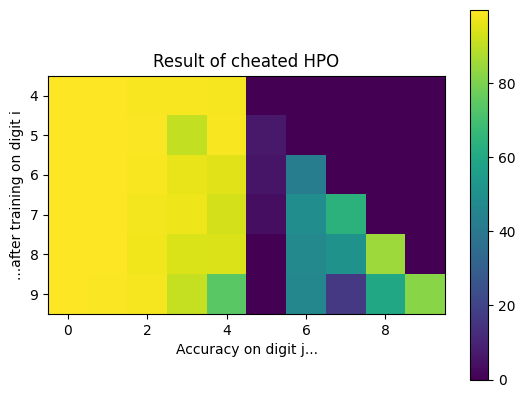

In [46]:
visualize_HPO_matrix(test_accs_matrix, 1, mode="cheated", savefig=True)

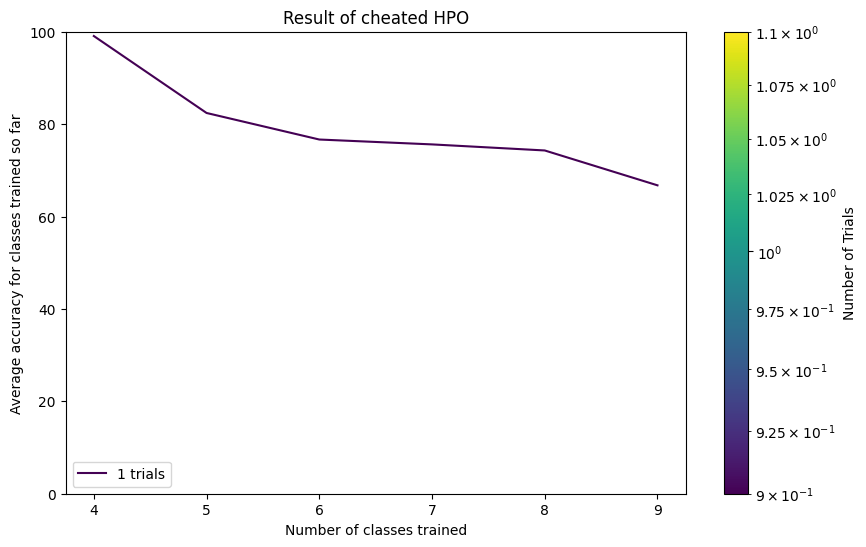

In [47]:
visualize_HPO_curve([test_accs_matrix], [1], mode="cheated", savefig=True)